# 1. Pendahuluan

Peneliti : Muhammad Azhar Rasyad

NIM : 0110217029

Dataset : https://www.kaggle.com/hendratno/covid19-indonesia

Berdasarkan sumber dari dataset yang peneliti ambil, terdapat sebuah permasalahan pada laporan COVID-19 di Indonesia karena berbagai faktor. Permasalahan tersebut yaitu **laporan kasus COVID-19 di Indonesia seringkali terlambat**, bisa 1 hari, 3 hari, 1 pekan, 2 pekan, atau bahkan lebih. 

Sehingga terkadang laporan kasus harian adalah kumpulan data kasus dari hari-hari sebelumnya. Hal ini menyebabkan **data laporan kasus harian COVID-19 di Indonesia tidak dapat menggambarkan keadaan yang sebenarnya**.

Oleh karena itu **diperlukan model yang dapat memperkirakan jumlah aktual kasus harian COVID-19 di Indonesia**. Hasil yang diharapkan adalah perkiraan jumlah kasus harian aktual COVID-19 di negara Indonesia.

Pada script ini difokuskan kepada prediksi 4 attribute yaitu New Cases, New Deaths, New Recovered, dan New Active Cases.

## 1.1. Persiapan Dataset

In [ ]:
# Mengambil library tambahan yang dibutuhkan sebagai berikut
! pip install pmdarima
import os
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
# Menggunakan Google Drive untuk menyimpan dataset
os.chdir('drive/MyDrive/Dataset')

In [ ]:
# Melihat isi dataset dan menjadikan index dengan attribute Date dari tanggal 2020-03-01 sampai 2020-12-31
dataset = pd.read_csv('covid_19_indonesia_time_series_all.csv', index_col='Date', parse_dates=True)
print('Baris dan Kolom Data', dataset.shape)
dataset

Baris dan Kolom Data (9959, 36)


,Location ISO Code,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Location Level,City or Regency,Province,Country,Continent,Island,Time Zone,Special Status,Total Regencies,Total Cities,Total Districts,Total Urban Villages,Total Rural Villages,Area (km2),Population,Population Density,Longitude,Latitude,New Cases per Million,Total Cases per Million,New Deaths per Million,Total Deaths per Million,Case Fatality Rate,Case Recovered Rate,Growth Factor of New Cases,Growth Factor of New Deaths
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-01,ID-JK,DKI Jakarta,2,0,0,2,489,20,39,430,Province,NaN,DKI Jakarta,Indonesia,Asia,Jawa,UTC+07:00,Daerah Khusus Ibu Kota,1,5.0,44,267.0,NaN,664,10846145,16334.31,106.836118,-6.204699,0.18,45.09,0.00,1.84,4.09%,7.98%,NaN,NaN
2020-03-02,ID-JK,DKI Jakarta,2,0,0,2,491,20,39,432,Province,NaN,DKI Jakarta,Indonesia,Asia,Jawa,UTC+07:00,Daerah Khusus Ibu Kota,1,5.0,44,267.0,NaN,664,10846145,16334.31,106.836118,-6.204699,0.18,45.27,0.00,1.84,4.07%,7.94%,1.00,1.00
2020-03-02,IDN,Indonesia,2,0,0,2,2,0,0,2,Country,NaN,NaN,Indonesia,Asia,NaN,NaN,NaN,416,98.0,7230,8488.0,74953.0,1916907,265185520,138.34,113.921327,-0.789275,0.01,0.01,0.00,0.00,0.00%,0.00%,NaN,NaN
2020-03-02,ID-JB,Jawa Barat,3,0,0,3,12,5,120,-113,Province,NaN,Jawa Barat,Indonesia,Asia,Jawa,UTC+07:00,NaN,18,9.0,627,645.0,5312.0,35378,45161325,1276.55,107.603708,-6.920432,0.07,0.27,0.00,0.11,41.67%,1000.00%,NaN,NaN
2020-03-02,ID-RI,Riau,1,0,0,1,2,1,1,0,Province,NaN,Riau,Indonesia,Asia,Sumatera,UTC+07:00,NaN,10,2.0,169,268.0,1591.0,87024,6074100,69.80,101.805109,0.511648,0.16,0.33,0.00,0.16,50.00%,50.00%,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31,ID-SG,Sulawesi Tenggara,38,0,24,14,7907,147,6696,1064,Province,NaN,Sulawesi Tenggara,Indonesia,Asia,Sulawesi,UTC+08:00,NaN,15,2.0,219,377.0,1911.0,38068,2635461,69.23,122.070311,-4.124689,14.42,3000.23,0.00,55.78,1.86%,84.68%,0.60,0.00
2020-12-31,ID-SA,Sulawesi Utara,88,1,0,87,9671,310,7003,2358,Province,NaN,Sulawesi Utara,Indonesia,Asia,Sulawesi,UTC+08:00,NaN,11,4.0,171,332.0,1507.0,13892,2641884,190.17,124.521240,1.259638,33.31,3660.65,0.38,117.34,3.21%,72.41%,2.59,0.25
2020-12-31,ID-SB,Sumatera Barat,117,3,26,88,23464,522,18030,4912,Province,NaN,Sumatera Barat,Indonesia,Asia,Sumatera,UTC+07:00,NaN,12,7.0,179,230.0,928.0,42013,5519245,131.37,100.465062,-0.850253,21.20,4251.31,0.54,94.58,2.22%,76.84%,0.94,3.00


## 1.2. Analisa Attribute Dataset

In [ ]:
# Menggunakan attribute yang digunakan untuk prediksi
dataset = dataset.loc[:, dataset.columns.intersection(['Date', 'New Cases', 'New Deaths', 'New Recovered', 'New Active Cases'])]
# Menjumlahkan semua tanggal yang sama sehingga hanya dibaca 1x
dataset = dataset.groupby(['Date']).sum()
# Melihat isi data
print('Baris dan Kolom Data', dataset.shape)
dataset

Baris dan Kolom Data (306, 4)


,New Cases,New Deaths,New Recovered,New Active Cases
Date,,,,
2020-03-01,2,0,0,2
2020-03-02,8,0,0,8
2020-03-03,3,1,0,2
2020-03-04,3,0,0,3
2020-03-05,1,1,0,0
...,...,...,...,...
2020-12-27,13056,469,13721,-1134
2020-12-28,11708,417,11849,-558
2020-12-29,15806,400,12918,2488


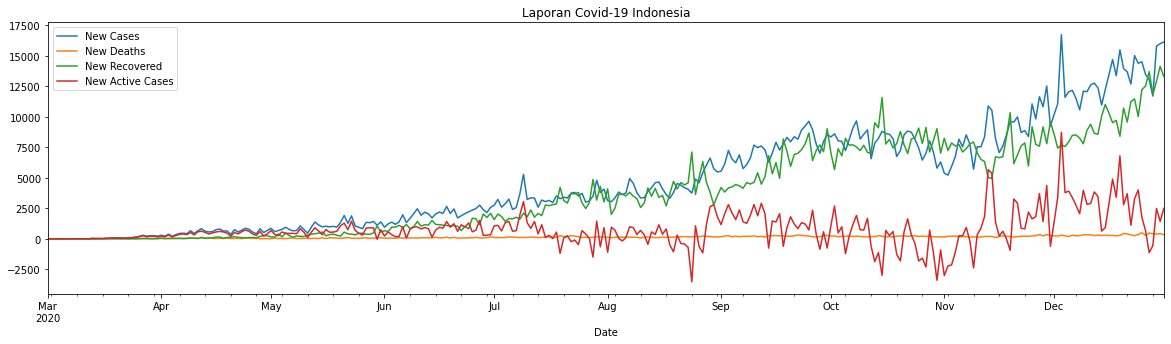

In [ ]:
# Visualisasi attribute-attribute yang digunakan untuk memprediksi attribute
dataset.plot(figsize=(20,5), legend=True, title='Laporan Covid-19 Indonesia')

# 2. Pembahasan

## 2.1. Membuat Data Train dan Data Test

In [ ]:
# Membuat split data train dan data test dari dataset yang sudah ada
print(dataset.shape)
train = dataset.iloc[:-30]
test = dataset.iloc[-30:]
print(train.shape, test.shape)

(306, 4)
(276, 4) (30, 4)


In [ ]:
train

,New Cases,New Deaths,New Recovered,New Active Cases
Date,,,,
2020-03-01,2,0,0,2
2020-03-02,8,0,0,8
2020-03-03,3,1,0,2
2020-03-04,3,0,0,3
2020-03-05,1,1,0,0
...,...,...,...,...
2020-11-27,11656,345,7599,3712
2020-11-28,10836,247,9181,1408
2020-11-29,12533,350,7801,4382


In [ ]:
test

,New Cases,New Deaths,New Recovered,New Active Cases
Date,,,,
2020-12-02,11067,228,7443,3396
2020-12-03,16738,305,7694,8739
2020-12-04,11606,245,7567,3794
2020-12-05,12060,193,7953,3914
2020-12-06,12176,304,8493,3379
2020-12-07,11512,245,8521,2746
2020-12-08,10586,263,8258,2065
2020-12-09,12116,336,7802,3978
2020-12-10,12066,332,8904,2830


## 2.2. Proses Attribute

In [ ]:
# Melakukan prediksi terhadap data test menggunakan model yang sudah dilatih dengan data train
start = len(train)
end = len(train) + len(test)-1
print(start)
print(end)

276
305


### 2.2.1. New Cases

In [ ]:
# Melakukan training pada data menggunakan algoritma auto_arima untuk menentukan model yang terbaik
warnings.filterwarnings('ignore')
# Attribute New Cases
auto_arima(dataset['New Cases'], trace=True, suppress_warnings=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4922.038, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5002.959, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4978.867, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4956.726, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5002.070, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4940.349, Time=0.64 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4939.981, Time=0.40 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4905.997, Time=0.96 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4918.980, Time=0.67 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4905.421, Time=1.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4921.163, Time=0.51 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=4857.632, Time=1.22 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=4878.070, Time=0.32 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=4844.090, Time=1.31 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  306
Model:               SARIMAX(5, 1, 3)   Log Likelihood               -2412.045
Date:                Sun, 24 Jan 2021   AIC                           4844.090
Time:                        15:25:01   BIC                           4881.293
Sample:                             0   HQIC                          4858.970
                                - 306                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    127.8492     61.991      2.062      0.039       6.349     249.349
ar.L1         -0.0254      0.066     -0.387      0.699      -0.154       0.103
ar.L2         -0.2415      0.081     -2.981      0.003      -0.400      -0.083
ar.L3         -0.7251      0.046    -15.893      0.000      -0.815      -0.636
ar.L4         -0.2138      0.043     -4.978      0.000      -0.298      -0.130
ar.L5         -0.4748      0.057     -8.376      0.000      -0.586      -0.364
ma.L1         -0.4965      0.082     -6.084      0.000      -0.656      -0.337
ma.L2          0.1252      0.104      1.201      0.230      -0.079       0.329
ma.L3          0.5952      0.101      5.898      0.000       0.397       0.793
sigma2      4.863e+05   3.03e+04     16.045      0.000    4.27e+05    5.46e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               878.33
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):              21.63   Skew:                             1.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

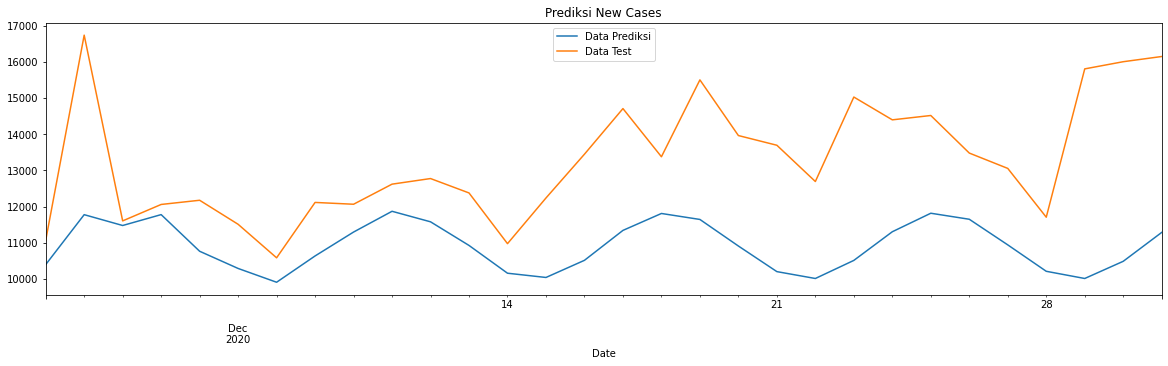

In [ ]:
# Membuat model menggunakan algoritma ARIMA dengan attribute pada data train
# Parameter order berdasarkan hasil train dari auto_arima sebelumnya yaitu Model: SARIMAX()
# Attribute New Cases
model1 = ARIMA(train['New Cases'], order=(5, 1, 3))
model1 = model1.fit(trend='nc')
# Attribute New Cases
pred1 = model1.predict(start=start, end=end, typ='levels')
pred1.index = dataset.index[start:end+1]
# Visualisasi data test dengan data prediksi
pred1.plot(legend=True, label='Data Prediksi', title='Prediksi New Cases')
test['New Cases'].plot(figsize=(20,5), legend=True, label='Data Test')

### 2.2.2. New Deaths

In [ ]:
# Attribute New Deaths
auto_arima(dataset['New Deaths'], trace=True, suppress_warnings=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3058.057, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3163.107, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3107.285, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3056.806, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3161.306, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3055.231, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3057.207, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3057.533, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3055.452, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3092.969, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3059.367, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.846 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  306
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1523.615
Date:                Sun, 24 Jan 2021   AIC                           3055.231
Time:                        15:25:04   BIC                           3070.112
Sample:                             0   HQIC                          3061.183
                                - 306                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0928      0.458      2.387      0.017       0.196       1.990
ar.L1          0.1414      0.052      2.722      0.006       0.040       0.243
ma.L1         -0.8045      0.036    -22.240      0.000      -0.875      -0.734
sigma2      1274.5582     71.497     17.827      0.000    1134.427    1414.689
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               163.93
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               6.10   Skew:                             0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

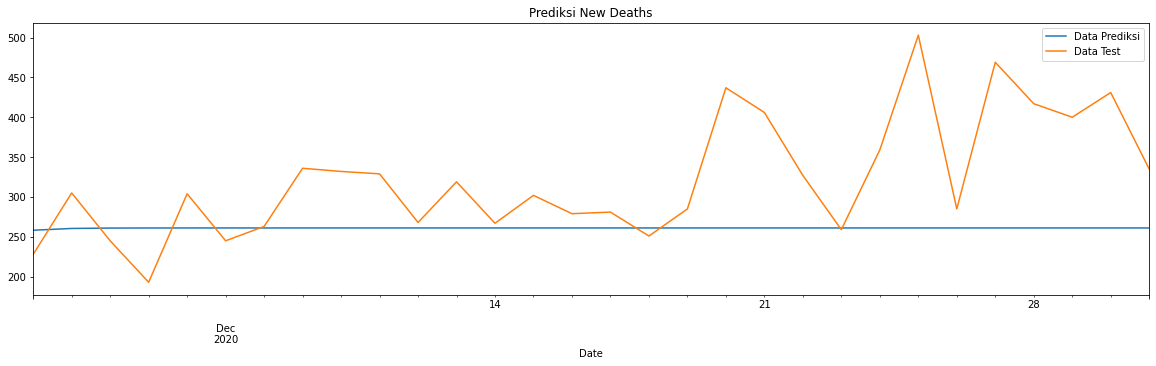

In [ ]:
# Attribute New Deaths
model2 = ARIMA(train['New Deaths'], order=(1, 1, 1))
model2 = model2.fit(trend='nc')
# Attribute New Deaths
pred2 = model2.predict(start=start, end=end, typ='levels')
pred2.index = dataset.index[start:end+1]
# Visualisasi data test dengan data prediksi
pred2.plot(legend=True, label='Data Prediksi', title='Prediksi New Deaths')
test['New Deaths'].plot(figsize=(20,5), legend=True, label='Data Test')

### 2.2.3. New Recovered

In [ ]:
# Attribute New Recovered
auto_arima(dataset['New Recovered'], trace=True, suppress_warnings=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5023.563, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4949.970, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4915.184, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5022.271, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4917.171, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4917.171, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4920.844, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 2.184 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  306
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2454.592
Date:                Sun, 24 Jan 2021   AIC                           4915.184
Time:                        15:25:07   BIC                           4926.345
Sample:                             0   HQIC                          4919.648
                                - 306                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     43.4933     16.419      2.649      0.008      11.313      75.673
ma.L1         -0.6562      0.029    -22.927      0.000      -0.712      -0.600
sigma2      5.718e+05   3.09e+04     18.510      0.000    5.11e+05    6.32e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               140.15
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              53.20   Skew:                             0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

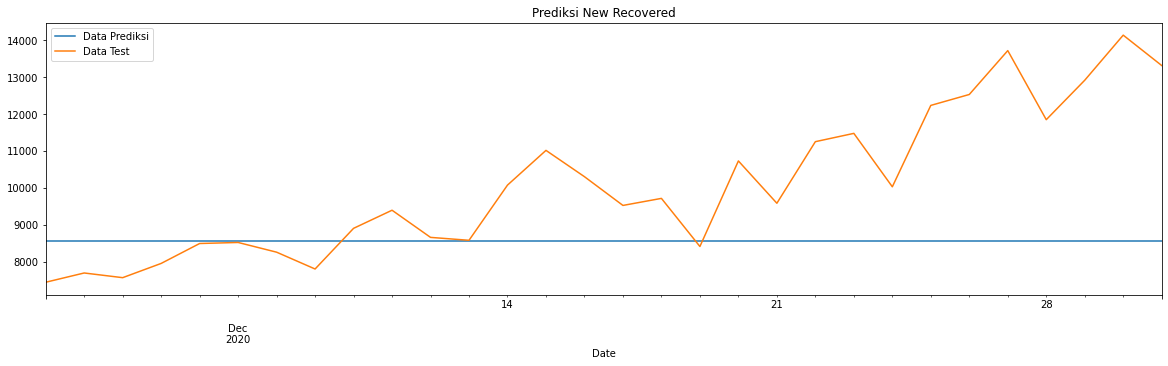

In [ ]:
# Attribute New Recovered
model3 = ARIMA(train['New Recovered'], order=(0, 1, 1))
model3 = model3.fit(trend='nc')
# Attribute New Recovered
pred3 = model3.predict(start=start, end=end, typ='levels')
pred3.index = dataset.index[start:end+1]
# Visualisasi data test dengan data prediksi
pred3.plot(legend=True, label='Data Prediksi', title='Prediksi New Recovered')
test['New Recovered'].plot(figsize=(20,5), legend=True, label='Data Test')

### 2.2.4. New Active Cases

In [ ]:
# Attribute New Active Cases
auto_arima(dataset['New Active Cases'], trace=True, suppress_warnings=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5155.363, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5240.776, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5202.130, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5167.138, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5238.789, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5156.488, Time=0.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5157.515, Time=0.35 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5157.011, Time=0.34 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5157.681, Time=0.56 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5154.570, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5157.323, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5194.932, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5152.810, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5165.217, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  306
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2573.405
Date:                Sun, 24 Jan 2021   AIC                           5152.810
Time:                        15:25:12   BIC                           5163.971
Sample:                             0   HQIC                          5157.274
                                - 306                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2912      0.065      4.501      0.000       0.164       0.418
ma.L1         -0.8528      0.040    -21.341      0.000      -0.931      -0.775
sigma2      1.245e+06   5.73e+04     21.739      0.000    1.13e+06    1.36e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               361.61
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):              50.96   Skew:                             0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

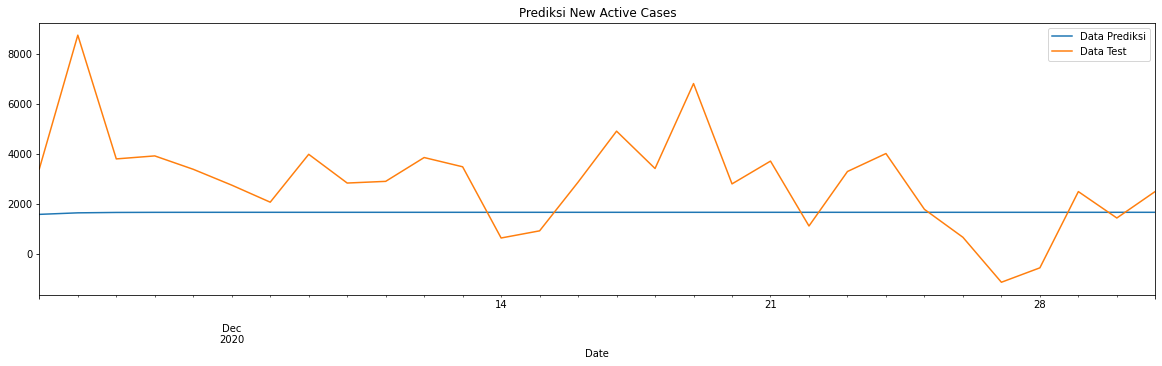

In [ ]:
# Attribute New Recovered
model4 = ARIMA(train['New Active Cases'], order=(1, 1, 1))
model4 = model4.fit(trend='nc')
# Attribute New Active Cases
pred4 = model4.predict(start=start, end=end, typ='levels')
pred4.index = dataset.index[start:end+1]
# Visualisasi data test dengan data prediksi
pred4.plot(legend=True, label='Data Prediksi', title='Prediksi New Active Cases')
test['New Active Cases'].plot(figsize=(20,5), legend=True, label='Data Test')

## 2.3. Menghitung Skor Model

In [ ]:
# Melihat rata-rata attribute dari data test
print('Mean New Cases : ', test['New Cases'].mean())
print('Mean New Deaths : ', test['New Deaths'].mean())
print('Mean New Recovered : ', test['New Recovered'].mean())
print('Mean New Active Cases : ', test['New Active Cases'].mean())

Mean New Cases :  13281.866666666667
Mean New Deaths :  322.0
Mean New Recovered :  10070.266666666666
Mean New Active Cases :  2889.6


In [ ]:
# Melihat score error antara data test dengan data prediksi
print('Error Prediksi New Cases : ', sqrt(mean_squared_error(pred1, test['New Cases'])))
print('Error Prediksi New Deaths : ', sqrt(mean_squared_error(pred2, test['New Deaths'])))
print('Error Prediksi New Recovered : ', sqrt(mean_squared_error(pred3, test['New Recovered'])))
print('Error Prediksi New Active Cases : ', sqrt(mean_squared_error(pred4, test['New Active Cases'])))

Error Prediksi New Cases :  2841.5570993456295
Error Prediksi New Deaths :  96.21198465320565
Error Prediksi New Recovered :  2456.5900142980504
Error Prediksi New Active Cases :  2282.1563680570857


## 2.4. Prediksi Attribute

In [ ]:
# Membuat model menggunakan dataset untuk memprediksi kasus yang akan terjadi
# Melakukan prediksi pada bulan Januari 2021 dengan menggunakan model2 sebelumnya
index_future_dates = pd.date_range(start='2021-01-01', end='2021-01-31')

# Attribute New Cases
model1 = ARIMA(dataset['New Cases'], order=(5, 1, 3))
model1 = model1.fit(trend='nc')
pred1 = model1.predict(start=len(dataset), end=len(dataset)+30, typ='levels').rename('ARIMA Predictions New Cases')
pred1.index= index_future_dates

# Attribute New Deaths
model2 = ARIMA(dataset['New Deaths'], order=(1, 1, 1))
model2 = model2.fit(trend='nc')
pred2 = model2.predict(start=len(dataset), end=len(dataset)+30, typ='levels').rename('ARIMA Predictions New Deaths')
pred2.index= index_future_dates

# Attribute New Recovered
model3 = ARIMA(dataset['New Recovered'], order=(0, 1, 1))
model3 = model3.fit(trend='nc')
pred3 = model3.predict(start=len(dataset), end=len(dataset)+30, typ='levels').rename('ARIMA Predictions New Recovered')
pred3.index= index_future_dates

# Attribute New Active Cases
model4 = ARIMA(dataset['New Active Cases'], order=(1, 1, 1))
model4 = model4.fit(trend='nc')
pred4 = model4.predict(start=len(dataset), end=len(dataset)+30, typ='levels').rename('ARIMA Predictions New Active Cases')
pred4.index= index_future_dates

# 3. Penutup

## 3.1. Prediksi Laporan Covid-19 Indonesia

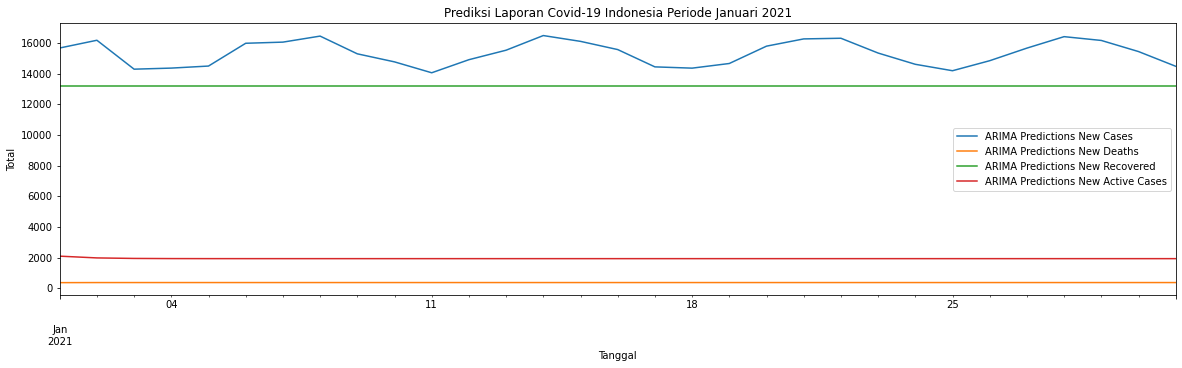

In [ ]:
# Visualisasi prediksi Covid-19 di Indonesia bulan Januari 2021
pred1.plot(figsize=(20,5), legend=True, xlabel='Tanggal', ylabel='Total', title='Prediksi Laporan Covid-19 Indonesia Periode Januari 2021')
pred2.plot(legend=True)
pred3.plot(legend=True)
pred4.plot(legend=True)

## 3.2. Perbandingan Laporan Covid-19 Indonesia

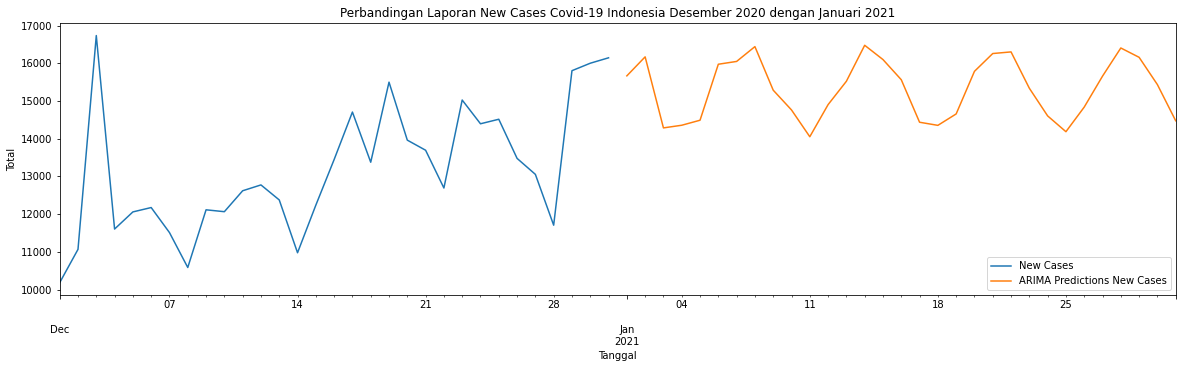

In [ ]:
# Attribute New Cases
dataset['New Cases'].loc[dataset.index >= '2020-12-01'].plot(figsize=(20,5), legend=True, xlabel='Tanggal', ylabel='Total', title='Perbandingan Laporan New Cases Covid-19 Indonesia Desember 2020 dengan Januari 2021')
pred1.plot(figsize=(20,5), legend=True)

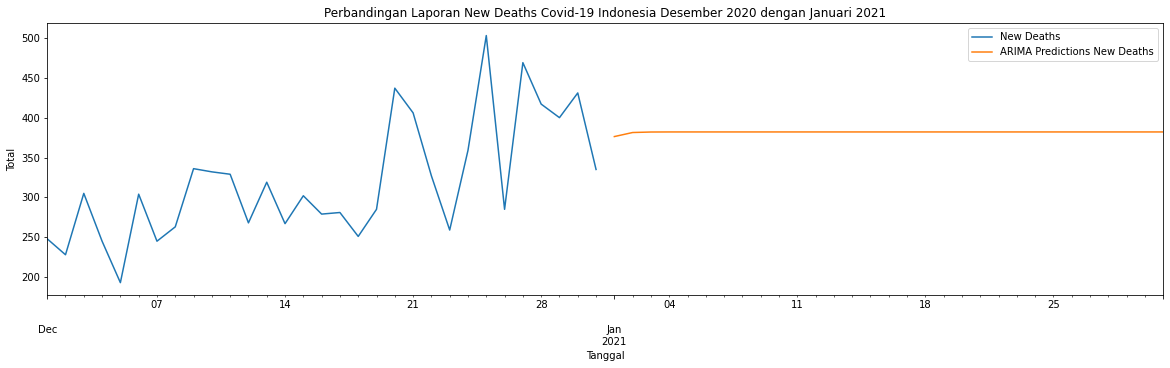

In [ ]:
# Attribute New Deaths
dataset['New Deaths'].loc[dataset.index >= '2020-12-01'].plot(figsize=(20,5), legend=True, xlabel='Tanggal', ylabel='Total', title='Perbandingan Laporan New Deaths Covid-19 Indonesia Desember 2020 dengan Januari 2021')
pred2.plot(figsize=(20,5), legend=True)

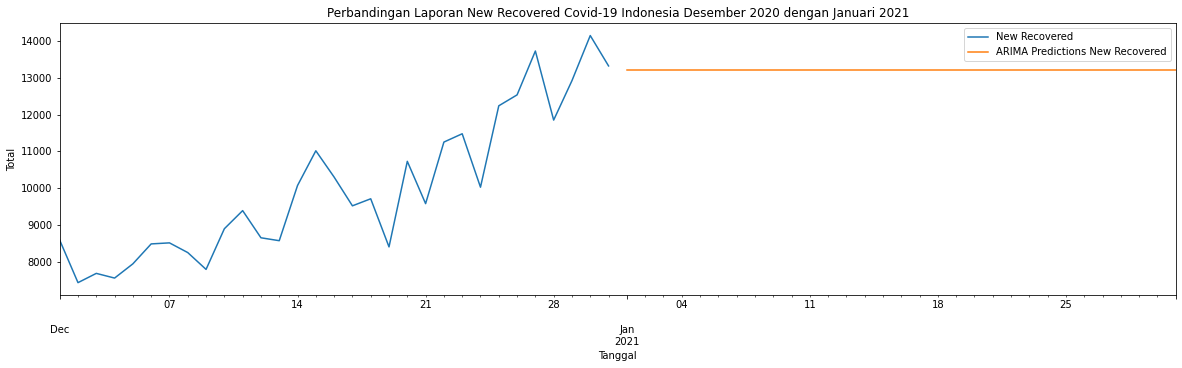

In [ ]:
# Attribute New Recovered
dataset['New Recovered'].loc[dataset.index >= '2020-12-01'].plot(figsize=(20,5), legend=True, xlabel='Tanggal', ylabel='Total', title='Perbandingan Laporan New Recovered Covid-19 Indonesia Desember 2020 dengan Januari 2021')
pred3.plot(figsize=(20,5), legend=True)

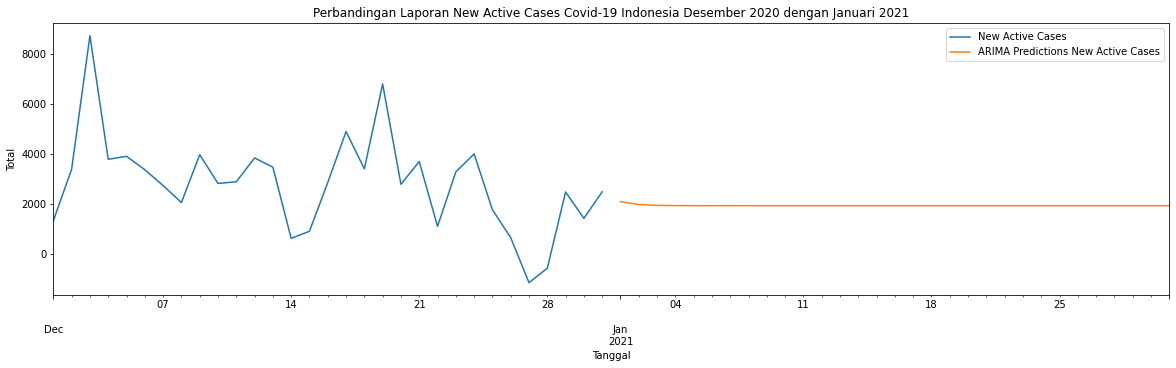

In [ ]:
# Attribute New Activate Cases
dataset['New Active Cases'].loc[dataset.index >= '2020-12-01'].plot(figsize=(20,5), legend=True, xlabel='Tanggal', ylabel='Total', title='Perbandingan Laporan New Active Cases Covid-19 Indonesia Desember 2020 dengan Januari 2021')
pred4.plot(figsize=(20,5), legend=True)

## 3.3. Kesimpulan

Prediksi untuk data covid-19 di Indonesia telah selesai dilakukan seperti yang terlihat pada grafik di atas, terdapat **4 attribute** yang diprediksi yaitu:
*   **New Cases :** Prediksi kasus baru Januari 2021 akan terjadi ketidakstabilan antara naik dan turunnya covid-19 di Indonesia dengan rentang 14000 hingga 16500.
*   **New Deaths :** Prediksi pada kasus kematian akibat covid-19 di Indonesia sekitar 350 hingga 400
*   **New Recovered :** Prediksi ini terjadi di sekitar angka 13000 hingga 13500 pada kasus yang sembuh dari covid-19
*   **New Active Cases :** Prediksi kasus yang masih aktif sekitar di angka 2000

Berdasarkan prediksi di atas dapat kita ambil insight yang dapat digunakan untuk mencegah hal tersebut terjadi atau bahkan mengurangi jumlah kasusnya. **Data prediksi tersebut memberikan wawasan bahwa jika kasus covid-19 di Indonesia ini tidak ditangani agar berkurang maka kemungkinan terburuknya kasus akan tetap bertambah seiring dengan berjalannya waktu.**

Oleh karena itu **diharapkan dengan adanya model ini dapat membuat suatu kebijakan oleh pihak-pihak yang berwenang dalam menangani kasus ini**, sehingga dapat mengurangi bertumbuhnya kasus covid-19 dikemudian hari. Contohnya seperti memperketat protokol kesehatan, menghimbau masyarakat Indonesia agar lebih paham, ataupun yang lainnya.

Mungkin itu saja prediksi yang peneliti dapat lakukan, serta peneliti mohon maaf apabila terdapat kesalahan dalam proses analisa data ataupun yang lainnya dikarenakan masih menggunakan model secara sederhana dan belum menerapkan beberapa ilmu statistik dengan lebih mendalam, **Sekian Terima Kasih.**


**Referensi :** https://www.youtube.com/watch?v=8FCDpFhd1zk&feature=emb_logo